In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import tensorflow as tf

## Downloading data

In [ ]:
! gdown https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz
!unzip -q train.zip

Downloading...
From (original): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz
From (redirected): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz&confirm=t&uuid=797d857d-c290-46e2-8521-8a779a5602b7
To: /content/train.zip
100% 898M/898M [00:11<00:00, 79.2MB/s]


Here we check that if the files are in right format or if they are not damaged.

In [ ]:
from pathlib import Path
import imghdr
import os

data_dir = "/content/train"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

/content/train/chicken/2a2a3166-2d2.jpg is not an image
/content/train/chicken/1b4ed8be-285.jpg is not an image
/content/train/chicken/e5574159-a60.jpg is not an image
/content/train/chicken/6fcf7983-225.jpg is not an image
/content/train/chicken/052f1133-141.jpg is not an image


We put all the files path and corresponding labels in a dataframe.

In [ ]:
image_dir=Path('/content/train')
filepaths=list(image_dir.glob(r'**/*.jpg'))
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='label')
images=pd.concat([filepaths,labels],axis=1)

In [ ]:
images

Filepath            label
0      /content/train/cheese_sandwich/e7fd6c31-d54.jpg  cheese_sandwich
1      /content/train/cheese_sandwich/de3e6585-529.jpg  cheese_sandwich
2      /content/train/cheese_sandwich/e84199ee-abe.jpg  cheese_sandwich
3      /content/train/cheese_sandwich/534b586e-f00.jpg  cheese_sandwich
4      /content/train/cheese_sandwich/7ff271e0-1dd.jpg  cheese_sandwich
...                                                ...              ...
24079            /content/train/steak/fd8ac7d5-24b.jpg            steak
24080            /content/train/steak/38ce4ddf-4fa.jpg            steak
24081            /content/train/steak/32c919c6-f4a.jpg            steak
24082            /content/train/steak/fac2a51a-26f.jpg            steak
24083            /content/train/steak/0ab12ecd-bb3.jpg            steak

[24084 rows x 2 columns]

As it is obvoious from the below table, our categories are not balanced.

In [ ]:
images.label.value_counts()

label
donuts             2395
hamburger          2376
chicken            2288
french_fries       2286
spaghetti          1509
baked_potato       1501
hot_dog            1057
pizza               887
omelette            715
falafel             709
caesar_salad        709
cheese_sandwich     708
fish                708
chicken_curry       707
ice_cream           705
chocolate_cake      702
eggs                699
lasagna             693
sushi               690
steak               681
baklava             680
cheesecake          679
Name: count, dtype: int64

We decide to down-sample our data to the minimum size of our categories( ~ 650). This will address the imabalanced problem of our data and make the training process less elaborate.

In [ ]:
samples=[]
for category in images.label.unique():
          category_slice=images.query('label==@category')
          samples.append(category_slice.sample(650,random_state=42))
image_df=pd.concat(samples,axis=0).sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
image_df

Filepath          label
0            /content/train/lasagna/43541944-dde.jpg        lasagna
1            /content/train/falafel/921c657b-3ca.jpg        falafel
2              /content/train/sushi/ef14c24e-9eb.jpg          sushi
3              /content/train/pizza/76908529-cfe.jpg          pizza
4            /content/train/chicken/3563a153-d1b.jpg        chicken
...                                              ...            ...
14295           /content/train/eggs/85581f8e-dea.jpg           eggs
14296  /content/train/chicken_curry/3de4d230-13c.jpg  chicken_curry
14297       /content/train/omelette/449c041b-a57.jpg       omelette
14298          /content/train/sushi/f9b6fd1a-909.jpg          sushi
14299      /content/train/ice_cream/fbd68339-88c.jpg      ice_cream

[14300 rows x 2 columns]

In [ ]:
image_df.label.value_counts()

label
lasagna            650
falafel            650
eggs               650
donuts             650
ice_cream          650
chocolate_cake     650
french_fries       650
caesar_salad       650
steak              650
fish               650
spaghetti          650
chicken_curry      650
omelette           650
baked_potato       650
cheese_sandwich    650
hamburger          650
hot_dog            650
baklava            650
chicken            650
pizza              650
sushi              650
cheesecake         650
Name: count, dtype: int64

We display one random image from each category.

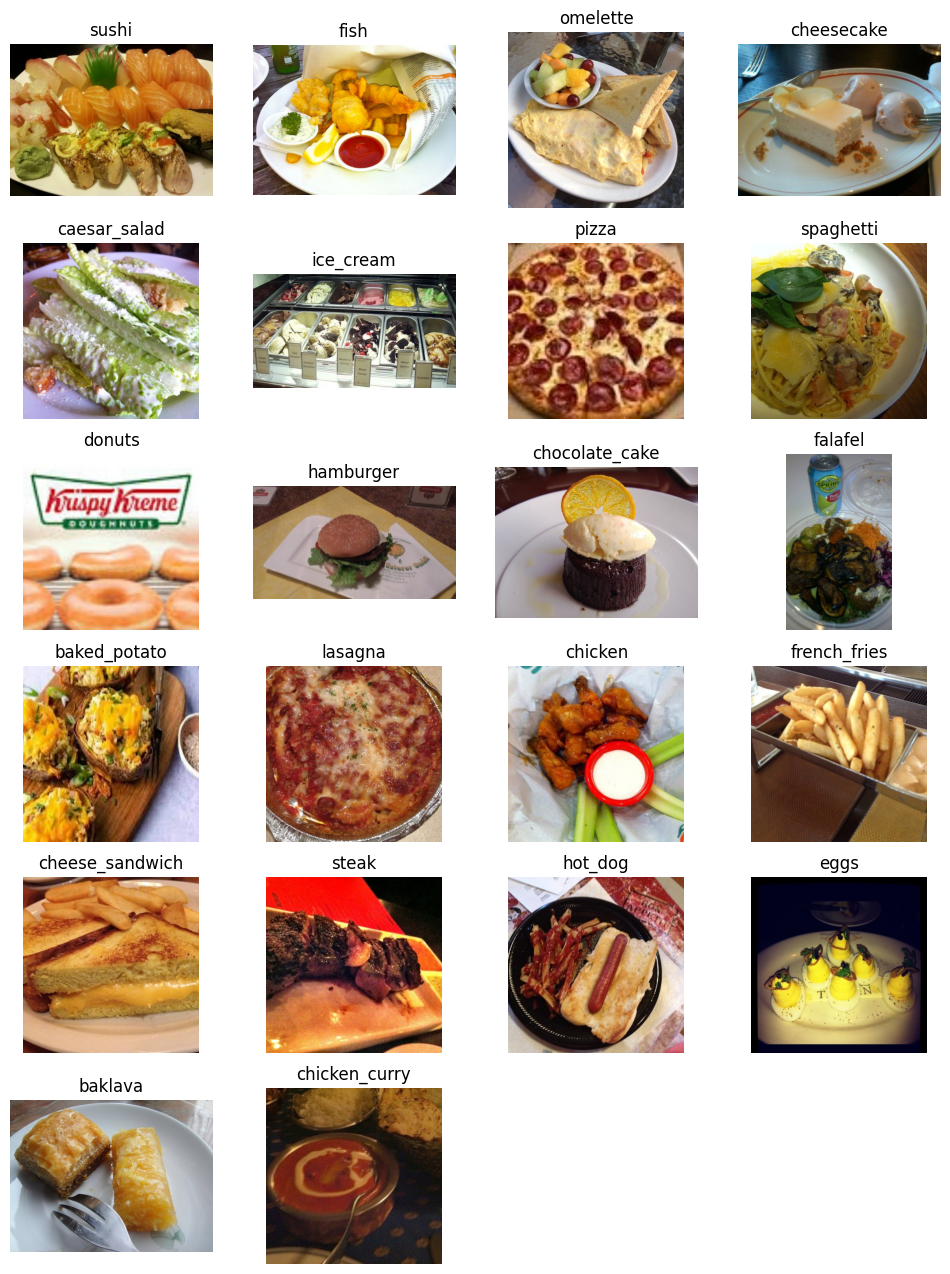

In [ ]:
plt.figure(figsize=(12, 16))
i=1
for category in image_df.label.unique():
  ax = plt.subplot(6, 4, i)
  plt.imshow(plt.imread(np.random.choice(image_df[image_df['label']==category]['Filepath'])))
  plt.title(category)
  plt.axis("off")
  i+=1

We split 0.15 of our data as test. ( In the following we also put 0.15 of train_df aside  for validation)

In [ ]:
from sklearn.model_selection import train_test_split
train_df,test_df =train_test_split(image_df,test_size=0.15,shuffle=True,random_state=42)



## VGG16

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.15)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)
from keras.applications.vgg16 import VGG16
pretrained_base = VGG16(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
pretrained_base.trainable = False

tf.keras.backend.clear_session()

model_1 = tf.keras.Sequential([
    #Augmentation
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(224, 224, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(22,activation='softmax')
])

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_1.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
from google.colab import drive
drive.mount('/content/drive')

checkpoint_filepath = '/content/drive/MyDrive/checkpoints_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               restore_best_weights=True)
history = model_1.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[model_checkpoint_callback,early_stopping]
)


Found 10332 validated image filenames belonging to 22 classes.
Found 1823 validated image filenames belonging to 22 classes.
Found 2145 validated image filenames belonging to 22 classes.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
323/323 [==============================] - 65s 194ms/step - loss: 2.5598 - accuracy: 0.2972 - val_loss: 1.6032 - val_accuracy: 0.5458
Epoch 2/30
323/323 [==============================] - 56s 174ms/step - loss: 1.7240 - accuracy: 0.4960 - val_loss: 1.3596 - val_accuracy: 0.6177
Epoch 3/30
323/323 [==============================] - 56s 174ms/step - loss: 1.4844 - accuracy: 0.5604 - val_loss: 1.2399 - val_accuracy: 0.6528
Epoch 4/30
323/323 [==============================] - 57s 176ms/step - loss: 1.3391 - accuracy: 0.5957 - val_loss: 1.1681 - val_accuracy: 0.6829
Epoch 5/30
323/323 [==============================] - 54s 167ms/step - loss: 1.2409 - accuracy: 0.6328 -

323/323 [==============================] - 46s 141ms/step - loss: 0.3723 - accuracy: 0.8803
Train Accuracy: 0.88%
57/57 [==============================] - 8s 137ms/step - loss: 0.9022 - accuracy: 0.7559
Validation Accuracy: 0.76%
Test Accuracy: 0.75%


Text(0, 0.5, 'Accuracy')

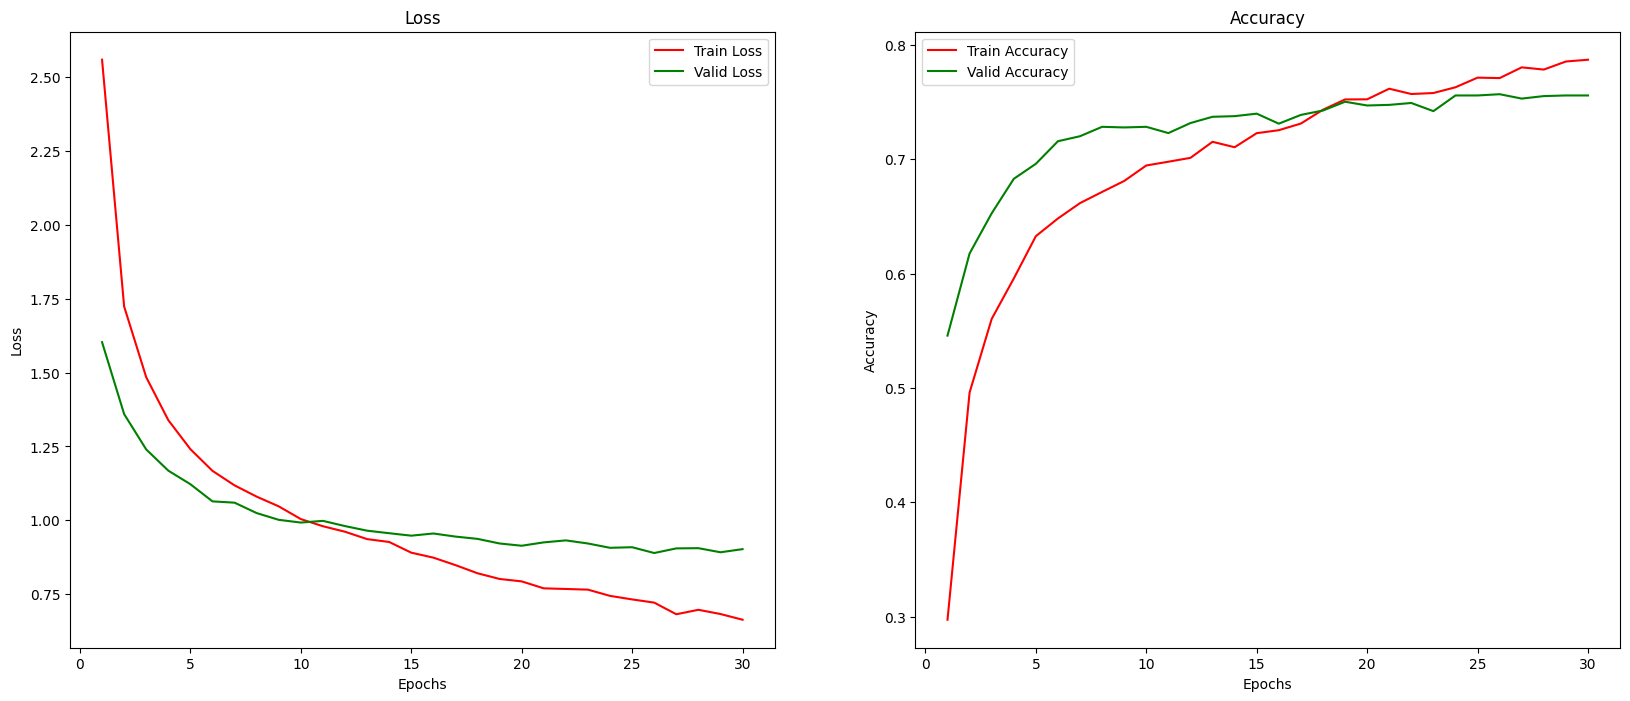

In [ ]:
results_train=model_1.evaluate(train_images,verbose=1)
print('Train Accuracy: {:.2f}%'.format(results_train[1]))

results_val=model_1.evaluate(val_images,verbose=1)
print('Validation Accuracy: {:.2f}%'.format(results_val[1]))

results_test=model_1.evaluate(test_images,verbose=0)
print('Test Accuracy: {:.2f}%'.format(results_test[1]))

tr_acc=history.history['accuracy']
tr_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs=[i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs,tr_loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'g',label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochs,tr_acc,'r',label='Train Accuracy')
plt.plot(epochs,val_acc,'g',label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Inception V3

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.15)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)
from keras.applications.inception_v3 import InceptionV3
pretrained_base = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = "imagenet")
pretrained_base.trainable = False

tf.keras.backend.clear_session()

model_1_2 = tf.keras.Sequential([
    #Augmentation
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(299, 299, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(22,activation='softmax')
])

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_1_2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
from google.colab import drive
drive.mount('/content/drive')

checkpoint_filepath = '/content/drive/MyDrive/checkpoints_1_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               restore_best_weights=True)
history = model_1_2.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[model_checkpoint_callback,early_stopping]
)


Found 10332 validated image filenames belonging to 22 classes.
Found 1823 validated image filenames belonging to 22 classes.
Found 2145 validated image filenames belonging to 22 classes.
87910968/87910968 [==============================] - 3s 0us/step
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
323/323 [==============================] - 126s 355ms/step - loss: 2.0185 - accuracy: 0.4368 - val_loss: 1.1286 - val_accuracy: 0.6764
Epoch 2/30
323/323 [==============================] - 65s 201ms/step - loss: 1.3169 - accuracy: 0.6102 - val_loss: 1.0035 - val_accuracy: 0.6999
Epoch 3/30
323/323 [==============================] - 64s 197ms/step - loss: 1.1556 - accuracy: 0.6590 - val_loss: 0.9107 - val_accuracy: 0.7411
Epoch 4/30
323/323 [==============================] - 64s 197ms/step - loss: 1.0660 - accuracy: 0.6846 - val_loss: 0.8859 - val_accuracy: 0.7493
Epoch 5/30
323/323 [==================

323/323 [==============================] - 54s 165ms/step - loss: 0.3511 - accuracy: 0.8844
Train Accuracy: 0.88%
57/57 [==============================] - 10s 166ms/step - loss: 0.8091 - accuracy: 0.7663
Validation Accuracy: 0.77%
Test Accuracy: 0.80%


Text(0, 0.5, 'Accuracy')

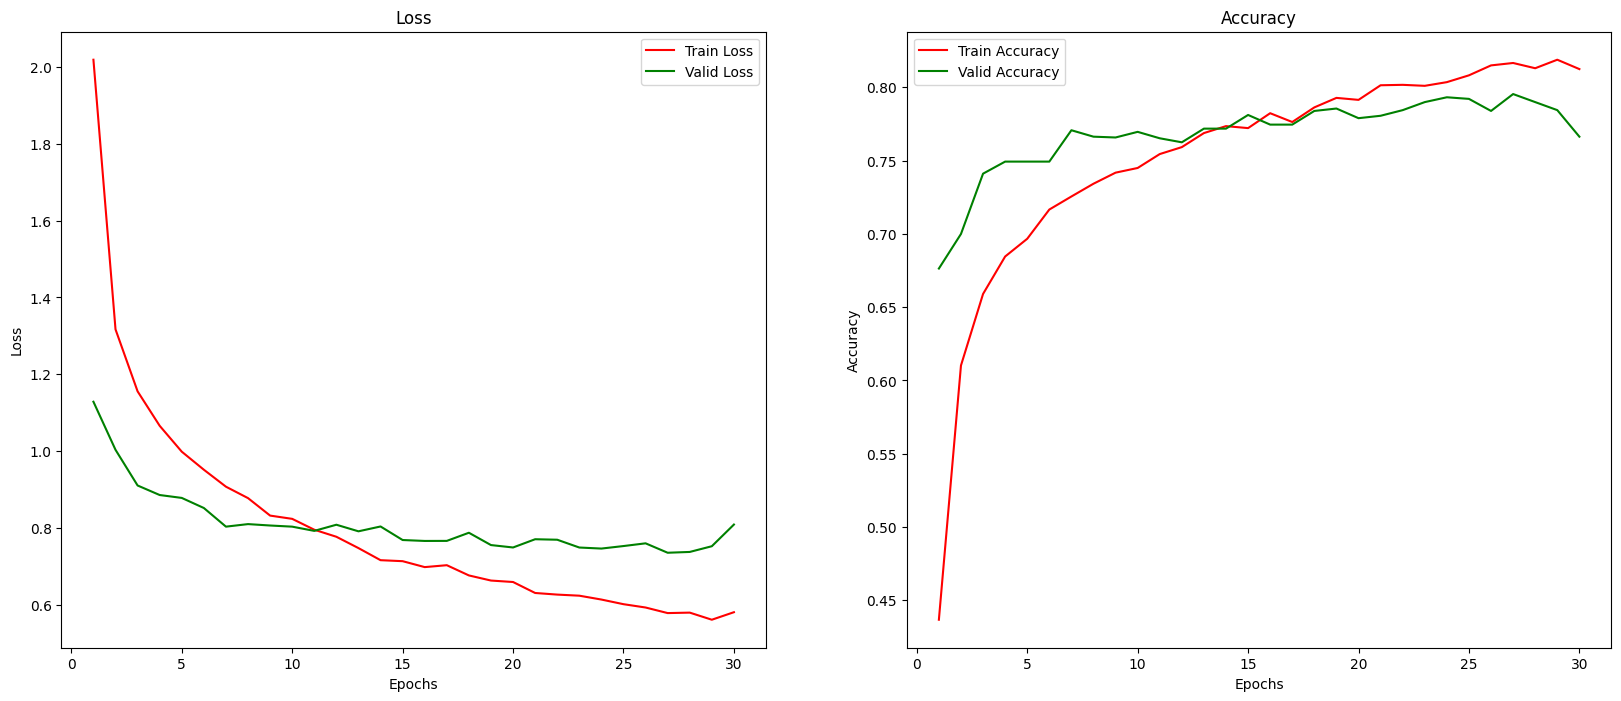

In [ ]:
results_train=model_1_2.evaluate(train_images,verbose=1)
print('Train Accuracy: {:.2f}%'.format(results_train[1]))

results_val=model_1_2.evaluate(val_images,verbose=1)
print('Validation Accuracy: {:.2f}%'.format(results_val[1]))

results_test=model_1_2.evaluate(test_images,verbose=0)
print('Test Accuracy: {:.2f}%'.format(results_test[1]))

tr_acc=history.history['accuracy']
tr_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs=[i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs,tr_loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'g',label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochs,tr_acc,'r',label='Train Accuracy')
plt.plot(epochs,val_acc,'g',label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Xception

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.15)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)

Found 10332 validated image filenames belonging to 22 classes.
Found 1823 validated image filenames belonging to 22 classes.
Found 2145 validated image filenames belonging to 22 classes.


In [ ]:
from keras.applications.xception import Xception
pretrained_base = Xception(input_shape = (299, 299, 3), include_top = False, weights = "imagenet")
pretrained_base.trainable = False


83683744/83683744 [==============================] - 3s 0us/step


In [ ]:

tf.keras.backend.clear_session()

model_2 = tf.keras.Sequential([
    #Augmentation
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(299, 299, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(22,activation='softmax')
])

In [ ]:
#optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
from google.colab import drive
drive.mount('/content/drive')

checkpoint_filepath = '/content/drive/MyDrive/checkpoints_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               restore_best_weights=True)
history = model_2.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[model_checkpoint_callback,early_stopping]
)


Mounted at /content/drive
Epoch 1/30
323/323 [==============================] - 135s 374ms/step - loss: 1.9456 - accuracy: 0.4525 - val_loss: 1.0864 - val_accuracy: 0.7098
Epoch 2/30
323/323 [==============================] - 91s 281ms/step - loss: 1.2577 - accuracy: 0.6335 - val_loss: 0.8671 - val_accuracy: 0.7438
Epoch 3/30
323/323 [==============================] - 90s 279ms/step - loss: 1.1134 - accuracy: 0.6660 - val_loss: 0.8405 - val_accuracy: 0.7586
Epoch 4/30
323/323 [==============================] - 90s 280ms/step - loss: 1.0032 - accuracy: 0.6956 - val_loss: 0.8137 - val_accuracy: 0.7729
Epoch 5/30
323/323 [==============================] - 88s 272ms/step - loss: 0.9397 - accuracy: 0.7131 - val_loss: 0.7991 - val_accuracy: 0.7729
Epoch 6/30
323/323 [==============================] - 89s 275ms/step - loss: 0.8659 - accuracy: 0.7388 - val_loss: 0.7589 - val_accuracy: 0.7822
Epoch 7/30
323/323 [==============================] - 90s 280ms/step - loss: 0.8414 - accuracy: 0.7441 

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/drive/My Drive/model_2/history.csv',index=False)

In [ ]:
model_2.save('/content/drive/My Drive/model_2')

In [ ]:
results_train=model_2.evaluate(train_images,verbose=1)
print('Train Accuracy: {:.2f}%'.format(results_train[1]))

323/323 [==============================] - 72s 224ms/step - loss: 0.3936 - accuracy: 0.8821
Train Accuracy: 0.88%


In [ ]:
results_val=model_2.evaluate(val_images,verbose=1)
print('Validation Accuracy: {:.2f}%'.format(results_val[1]))

57/57 [==============================] - 15s 250ms/step - loss: 0.7040 - accuracy: 0.8020
Validation Accuracy: 0.80%


In [ ]:
results_test=model_2.evaluate(test_images,verbose=0)
print('Test Accuracy: {:.2f}%'.format(results_test[1]))

Test Accuracy: 0.81%


Text(0, 0.5, 'Accuracy')

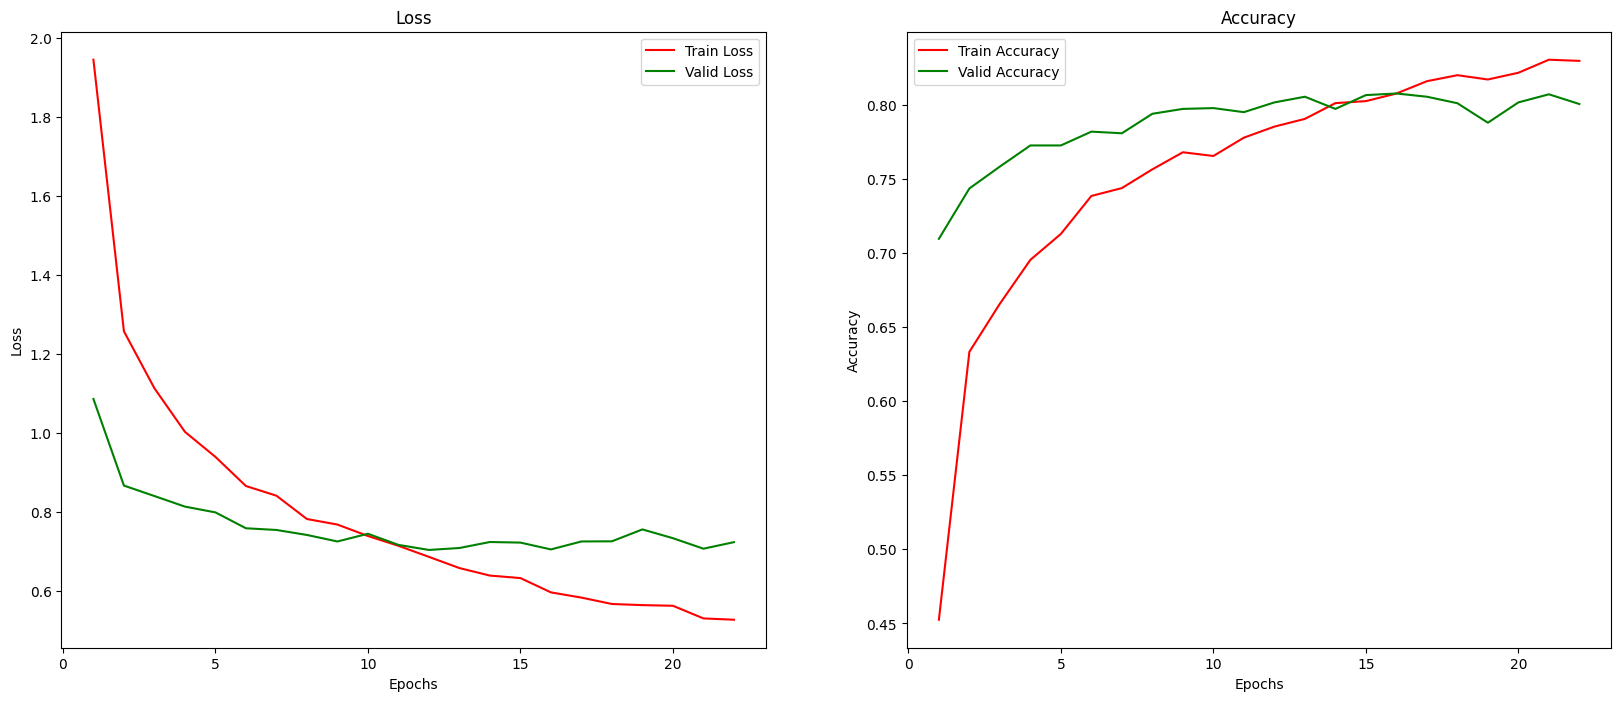

In [ ]:
tr_acc=history.history['accuracy']
tr_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs=[i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs,tr_loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'g',label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochs,tr_acc,'r',label='Train Accuracy')
plt.plot(epochs,val_acc,'g',label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
predictions=np.argmax(model_2.predict(test_images),axis=1)
cm=confusion_matrix(test_images.labels,predictions)
clr=classification_report(test_images.labels,predictions)


68/68 [==============================] - 18s 230ms/step


Text(220.72222222222223, 0.5, 'Actual')

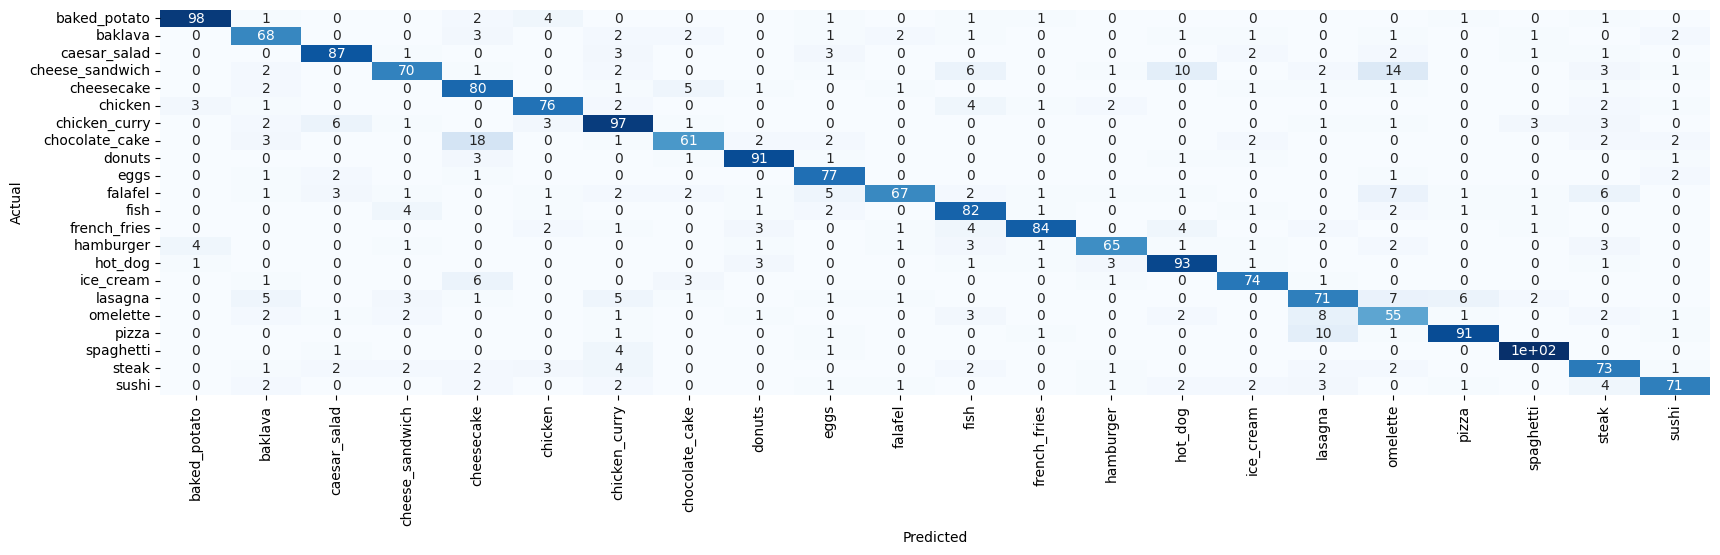

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.heatmap(cm,annot=True,cmap='Blues',cbar=False)
plt.xticks(ticks=np.arange(22)+0.5,labels=test_images.class_indices,rotation=90)
plt.yticks(ticks=np.arange(22)+0.5,labels=test_images.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [ ]:
print(clr)

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       110
           1       0.74      0.80      0.77        85
           2       0.85      0.87      0.86       100
           3       0.82      0.62      0.71       113
           4       0.67      0.85      0.75        94
           5       0.84      0.83      0.84        92
           6       0.76      0.82      0.79       118
           7       0.80      0.66      0.72        93
           8       0.88      0.92      0.90        99
           9       0.79      0.92      0.85        84
          10       0.91      0.65      0.76       103
          11       0.75      0.85      0.80        96
          12       0.92      0.82      0.87       102
          13       0.87      0.78      0.82        83
          14       0.81      0.89      0.85       104
          15       0.86      0.86      0.86        86
          16       0.70      0.69      0.70       103
          17       0.57    

Let's check what we get if we remove early stopping from our model.

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.15)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)
from keras.applications.xception import Xception
pretrained_base = Xception(input_shape = (299, 299, 3), include_top = False, weights = "imagenet")
pretrained_base.trainable = False

tf.keras.backend.clear_session()

model_3 = tf.keras.Sequential([
    #Augmentation
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(299, 299, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(22,activation='softmax')
])

#optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
from google.colab import drive
drive.mount('/content/drive')

#checkpoint_filepath = '/content/drive/MyDrive/checkpoints_2'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
 #   monitor='val_loss',
 #   mode='max',
#    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               restore_best_weights=True)
history_3 = model_3.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
#    callbacks=[model_checkpoint_callback,early_stopping]
)


Found 10332 validated image filenames belonging to 22 classes.
Found 1823 validated image filenames belonging to 22 classes.
Found 2145 validated image filenames belonging to 22 classes.
83683744/83683744 [==============================] - 0s 0us/step
Mounted at /content/drive
Epoch 1/30
323/323 [==============================] - 116s 314ms/step - loss: 1.9290 - accuracy: 0.4636 - val_loss: 1.1110 - val_accuracy: 0.7010
Epoch 2/30
323/323 [==============================] - 96s 298ms/step - loss: 1.2719 - accuracy: 0.6297 - val_loss: 0.8450 - val_accuracy: 0.7449
Epoch 3/30
323/323 [==============================] - 97s 301ms/step - loss: 1.1047 - accuracy: 0.6739 - val_loss: 0.8101 - val_accuracy: 0.7553
Epoch 4/30
323/323 [==============================] - 98s 302ms/step - loss: 1.0050 - accuracy: 0.6957 - val_loss: 0.7916 - val_accuracy: 0.7515
Epoch 5/30
323/323 [==============================] - 104s 320ms/step - loss: 0.9380 - accuracy: 0.7123 - val_loss: 0.7612 - val_accuracy: 0.

323/323 [==============================] - 89s 275ms/step - loss: 0.2290 - accuracy: 0.9263
Train Accuracy: 0.93%
57/57 [==============================] - 15s 258ms/step - loss: 0.7409 - accuracy: 0.7992
Validation Accuracy: 0.80%
68/68 [==============================] - 21s 309ms/step - loss: 0.6879 - accuracy: 0.8154
Test Accuracy: 0.82%


Text(0, 0.5, 'Accuracy')

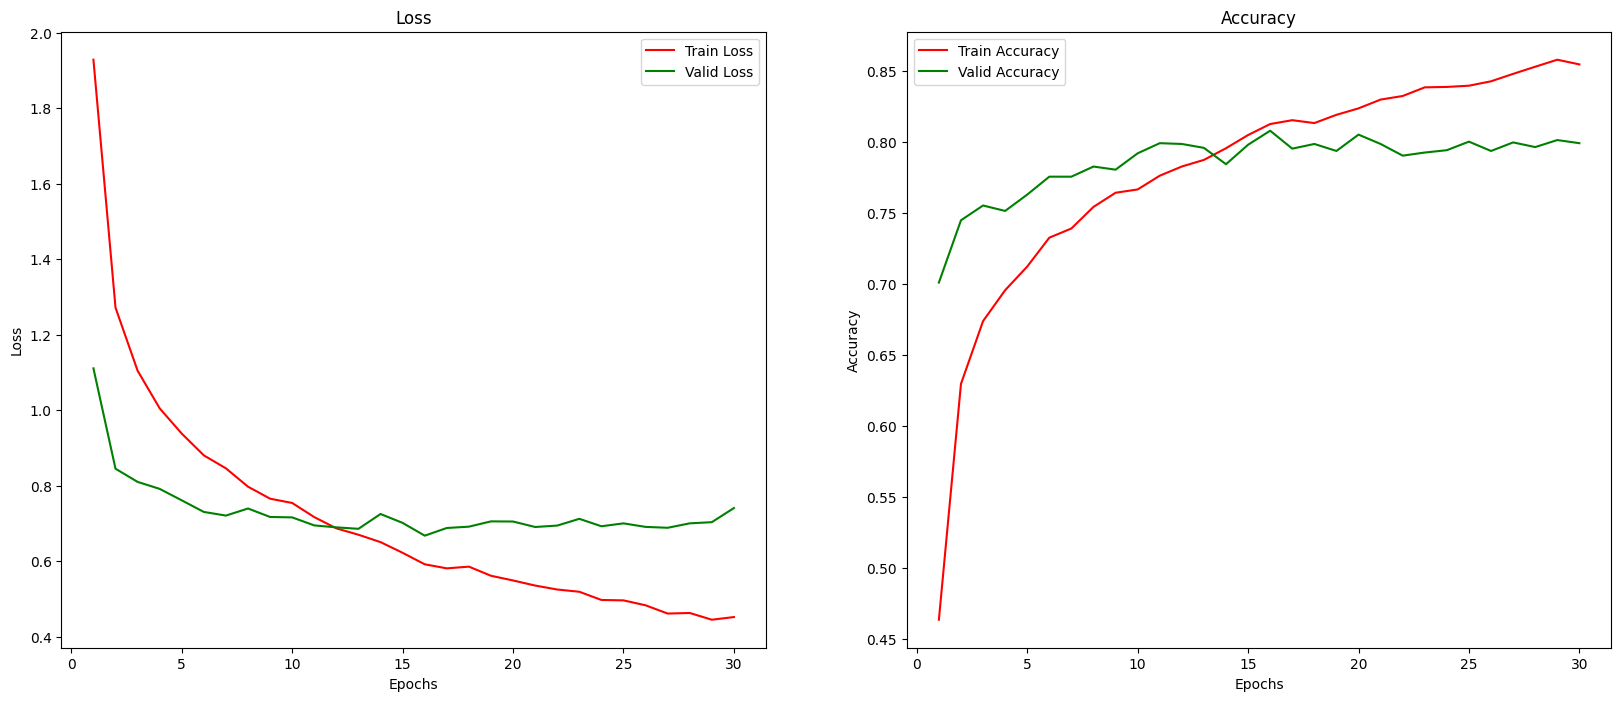

In [ ]:
results_train=model_3.evaluate(train_images,verbose=1)
print('Train Accuracy: {:.2f}%'.format(results_train[1]))

results_val=model_3.evaluate(val_images,verbose=1)
print('Validation Accuracy: {:.2f}%'.format(results_val[1]))

results_test=model_3.evaluate(test_images,verbose=1)
print('Test Accuracy: {:.2f}%'.format(results_test[1]))

tr_acc=history_3.history['accuracy']
tr_loss=history_3.history['loss']
val_acc=history_3.history['val_accuracy']
val_loss=history_3.history['val_loss']

epochs=[i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs,tr_loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'g',label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochs,tr_acc,'r',label='Train Accuracy')
plt.plot(epochs,val_acc,'g',label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


As it is obvious from loss and accuracy plot for our models, the validation loss come to a plateau after few epochs. We want to check if dynamic scenario for learning rate parameter, can improve our results.

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.15)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)
from keras.applications.xception import Xception
pretrained_base = Xception(input_shape = (299, 299, 3), include_top = False, weights = "imagenet")
pretrained_base.trainable = False

tf.keras.backend.clear_session()

model_4 = tf.keras.Sequential([
    #Augmentation
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(299, 299, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(22,activation='softmax')
])

#optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model_4.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
from google.colab import drive
drive.mount('/content/drive')

#checkpoint_filepath = '/content/drive/MyDrive/checkpoints_2'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
 #   monitor='val_loss',
 #   mode='max',
#    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               restore_best_weights=True)
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

history_4 = model_4.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[rlrp]
)


Found 10332 validated image filenames belonging to 22 classes.
Found 1823 validated image filenames belonging to 22 classes.
Found 2145 validated image filenames belonging to 22 classes.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
323/323 [==============================] - 117s 337ms/step - loss: 1.4575 - accuracy: 0.5917 - val_loss: 0.9548 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 2/30
323/323 [==============================] - 99s 305ms/step - loss: 1.0751 - accuracy: 0.6830 - val_loss: 0.8068 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 3/30
323/323 [==============================] - 98s 302ms/step - loss: 0.9702 - accuracy: 0.7061 - val_loss: 0.7952 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 4/30
323/323 [==============================] - 98s 302ms/step - loss: 0.8679 - accuracy: 0.7310 - val_loss: 0.7376 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 5/30
323/323 [==============================]

In [ ]:
model_4.save('/content/drive/My Drive/model_4')

323/323 [==============================] - 81s 250ms/step - loss: 0.2701 - accuracy: 0.9131
Train Accuracy: 0.91%
57/57 [==============================] - 14s 247ms/step - loss: 0.6302 - accuracy: 0.8108
Validation Accuracy: 0.81%
68/68 [==============================] - 17s 245ms/step - loss: 0.6322 - accuracy: 0.8261
Test Accuracy: 0.83%


Text(0, 0.5, 'Accuracy')

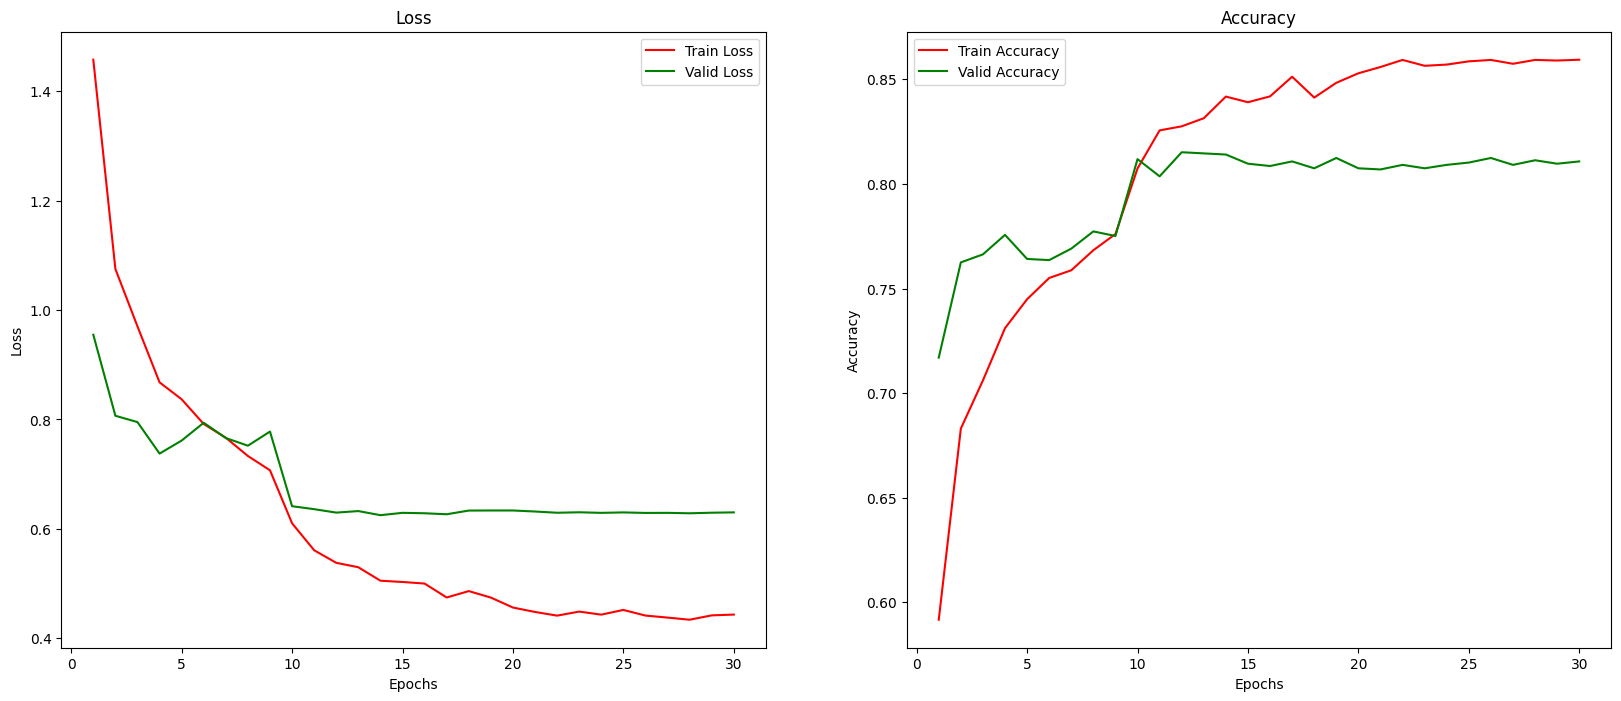

In [ ]:
results_train=model_4.evaluate(train_images,verbose=1)
print('Train Accuracy: {:.2f}%'.format(results_train[1]))

results_val=model_4.evaluate(val_images,verbose=1)
print('Validation Accuracy: {:.2f}%'.format(results_val[1]))

results_test=model_4.evaluate(test_images,verbose=1)
print('Test Accuracy: {:.2f}%'.format(results_test[1]))

tr_acc=history_4.history['accuracy']
tr_loss=history_4.history['loss']
val_acc=history_4.history['val_accuracy']
val_loss=history_4.history['val_loss']

epochs=[i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs,tr_loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'g',label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochs,tr_acc,'r',label='Train Accuracy')
plt.plot(epochs,val_acc,'g',label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

68/68 [==============================] - 18s 251ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       100
           1       0.80      0.73      0.76        84
           2       0.84      0.88      0.86       106
           3       0.85      0.76      0.80        99
           4       0.70      0.83      0.76        86
           5       0.88      0.73      0.80        95
           6       0.66      0.86      0.75        92
           7       0.84      0.83      0.84        83
           8       0.95      0.82      0.88       110
           9       0.90      0.83      0.86       103
          10       0.86      0.74      0.80        93
          11       0.83      0.89      0.85        96
          12       0.93      0.85      0.89       113
          13       0.81      0.96      0.88        92
          14       0.83      0.87      0.85        94
          15       0.72      0.89      0.80        79
          16       0.72  

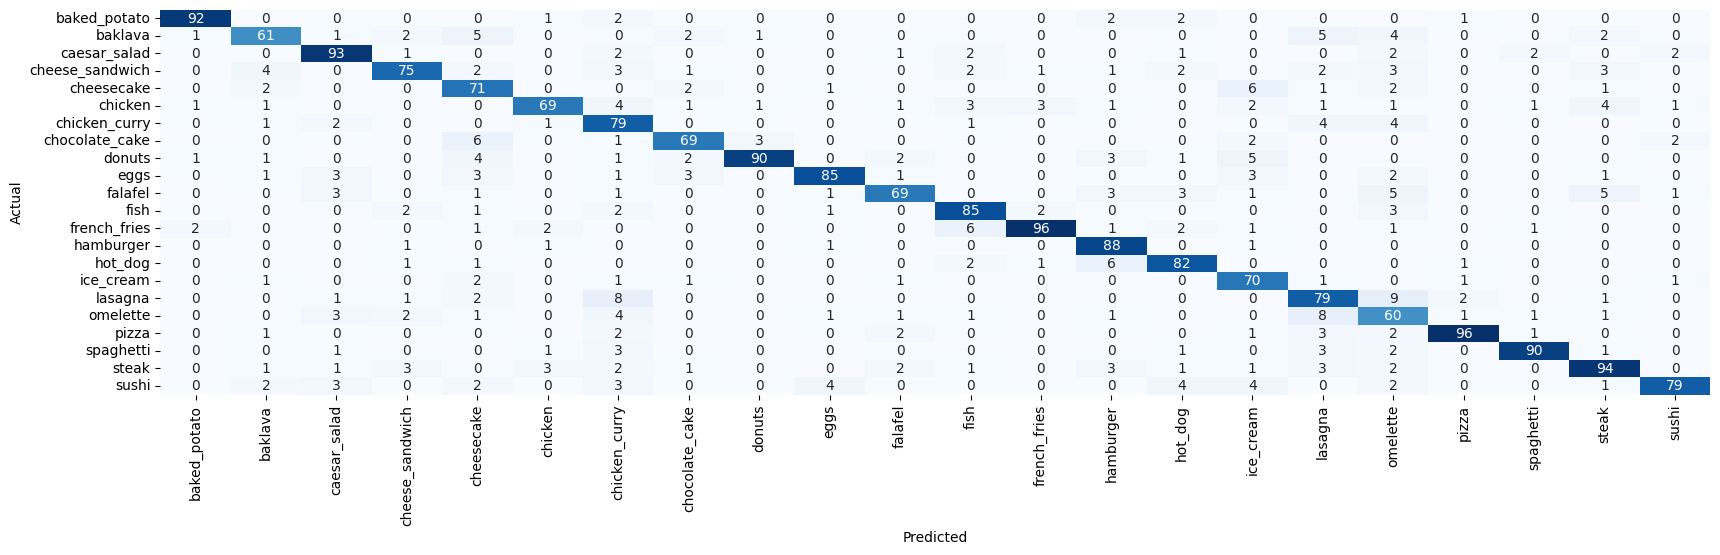

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
predictions=np.argmax(model_4.predict(test_images),axis=1)
cm=confusion_matrix(test_images.labels,predictions)
clr=classification_report(test_images.labels,predictions)

import seaborn as sns
plt.figure(figsize=(20,5))
sns.heatmap(cm,annot=True,cmap='Blues',cbar=False)
plt.xticks(ticks=np.arange(22)+0.5,labels=test_images.class_indices,rotation=90)
plt.yticks(ticks=np.arange(22)+0.5,labels=test_images.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(clr)


In [ ]:
from sklearn.metrics import f1_score
print(f1_score(test_images.labels,predictions,average='micro'))

0.8261072261072261


In [ ]:
model_4.save('/content/drive/My Drive/model_4')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/model_2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
results_train=loaded_model.evaluate(train_images,verbose=1)
print('Train Accuracy: {:.2f}%'.format(results_train[1]))

323/323 [==============================] - 92s 262ms/step - loss: 0.5329 - accuracy: 0.8438
Train Accuracy: 0.84%


In [ ]:
results_val=loaded_model.evaluate(val_images,verbose=1)
print('Validation Accuracy: {:.2f}%'.format(results_val[1]))

57/57 [==============================] - 20s 340ms/step - loss: 0.5496 - accuracy: 0.8332
Validation Accuracy: 0.83%


In [ ]:
results_test=loaded_model.evaluate(test_images,verbose=0)
print('Test Accuracy: {:.2f}%'.format(results_test[1]))

Test Accuracy: 0.85%


Here we display some of the test image with actual and predicted labels.

In [ ]:
predictions=np.argmax(loaded_model.predict(test_images),axis=1)
predictions

68/68 [==============================] - 580s 9s/step


array([ 1,  2,  9, ..., 14, 20, 16])

In [ ]:
def maping_to_cat(x):
     for k,v in test_images.class_indices.items():
         if v==x:
             return k


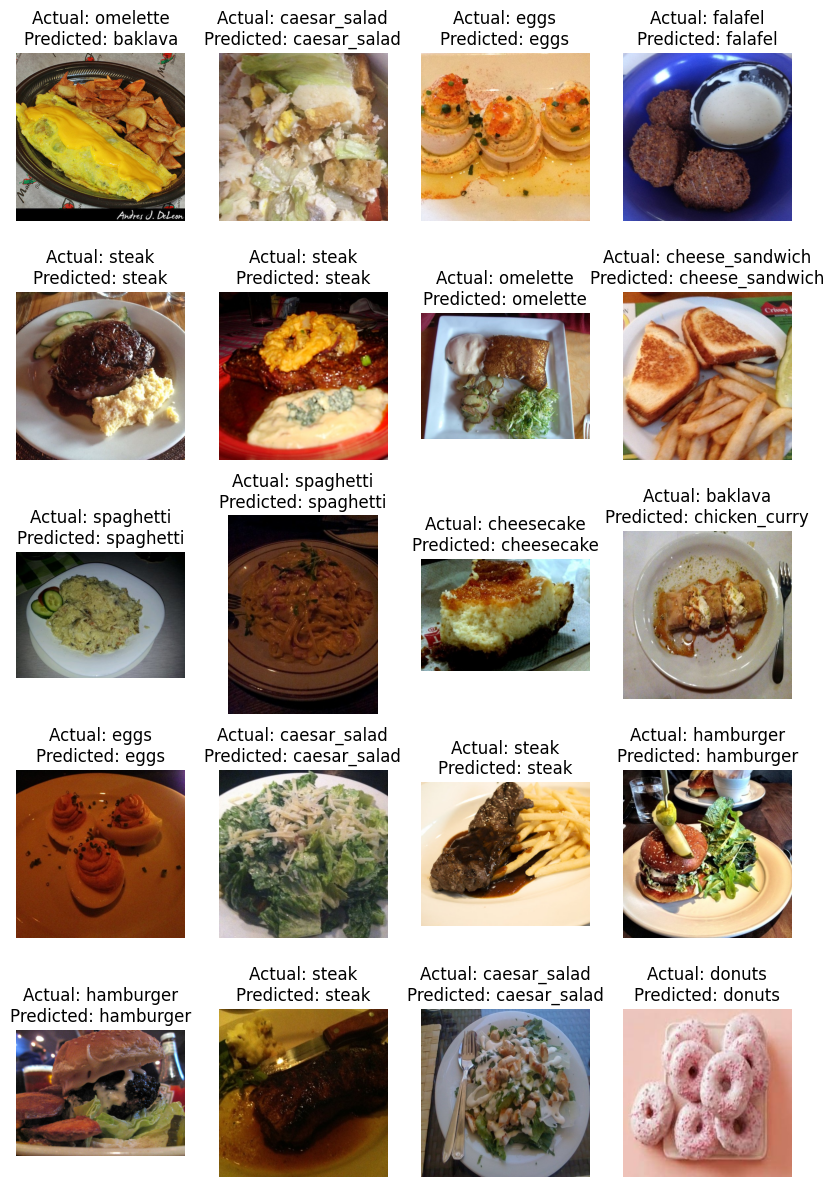

In [ ]:
from matplotlib.image import imread
plt.figure(figsize=(10, 15))
for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(imread(test_df.iloc[i,0]))
        plt.title('Actual: '+ test_df.iloc[i,1]+'\nPredicted: '+ maping_to_cat(predictions[i]))
        plt.axis("off")